# Renyi's alpha entropy

paper: https://arxiv.org/pdf/1804.06537.pdf

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import numpy as np
import pycuda.driver as cuda
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from models import DNN, CNN

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
print("Setting Info")
print("=========")
print("- use_cuda: ", use_cuda)
print("- Path: ", os.getcwd())
print("- PyTorch", torch.__version__)
print("- Python: ", sys.version)

Setting Info
- use_cuda:  True
- Path:  /home/uchiumi/JNNS2019/mnist_pytorch
- PyTorch 1.0.1.post2
- Python:  3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


## Load Model

In [3]:
# model reload
model = DNN()
PRETRAINED_MODEL_PATH = "/home/uchiumi/JNNS2019/mnist_pytorch/train_log/dnn_mnist__2019-0425-1923.pth"
model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))

## Data Loader

cf.) https://www.aiworkbox.com/lessons/examine-mnist-dataset-from-pytorch-torchvision

In [4]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [5]:
X_train_0 = np.asarray(mnist_trainset[0][0]) # image
y_train_0 = mnist_trainset[0][1] # label

In [6]:
# train
train_loader_for_MI = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [7]:
# test
test_loader_for_MI = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

## Get layer values (the state of each nodes)

In [8]:
def get_nodes_with_train_data(model):
    model.eval()
    list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader_for_MI):
            result = model(data)
            list.append(result)
    return list

In [9]:
def get_nodes_with_test_data(model):
    model.eval()
    list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_for_MI):            
            result = model(data)
            list.append(result)
    return list

In [10]:
list = get_nodes_with_train_data(model)

In [11]:
len(list)

60000

In [12]:
list[0].keys()

dict_keys(['model_output', 'fc4_output', 'fc1_output', 'fc2_output', 'model_input', 'fc3_output'])

In [13]:
print("model_input", list[0]["model_input"].shape)
print("fc1_output",list[0]["fc1_output"].shape)
print("fc2_output",list[0]["fc2_output"].shape)
print("fc3_output",list[0]["fc3_output"].shape)
print("fc4_output",list[0]["fc4_output"].shape)
print("model_output",list[0]["model_output"].shape)

model_input torch.Size([1, 784])
fc1_output torch.Size([1, 1024])
fc2_output torch.Size([1, 512])
fc3_output torch.Size([1, 256])
fc4_output torch.Size([1, 128])
model_output torch.Size([1, 10])


In [14]:
model_input = []
fc1_output = []
fc2_output = []
fc3_output = []
fc4_output = []
model_output = []

for i in range(len(train_loader_for_MI)):
    model_input.append(list[i]["model_input"].data.numpy().flatten())
    fc1_output.append(list[i]["fc1_output"].data.numpy().flatten())
    fc2_output.append(list[i]["fc2_output"].data.numpy().flatten())
    fc3_output.append(list[i]["fc3_output"].data.numpy().flatten())
    fc4_output.append(list[i]["fc4_output"].data.numpy().flatten())
    model_output.append(list[i]["model_output"].data.numpy().flatten())

In [15]:
model_input = np.array(model_input)
fc1_output = np.array(fc1_output)
fc2_output = np.array(fc1_output)
fc3_output = np.array(fc1_output)
fc4_output = np.array(fc1_output)
model_output = np.array(model_output)

## Renyi's alpha entropy

$$
\begin{align}
    H_{\alpha}(p) &:= \frac{1}{1 - \alpha} \log_2 \int_{\chi} p^{\alpha}(x) ~ dx \\
    H_{\alpha}(p) &:= \frac{1}{1 - \alpha} \log_2 \sum_{x \in \chi} p^{\alpha}(x)
\end{align}
$$

$$
    S_{\alpha}(A) := \frac{1}{1 - \alpha} \log_{2} {\rm tr}(A^{\alpha}) = \frac{1}{1 - \alpha} \log_{2} \left( \sum_{i=1}^{n} { \{ \lambda_{i} (A) \} }^{\alpha} \right) \\ \\
    where, ~~~ A_{ij} = \frac{1}{n} \frac{K_{ij}}{\sqrt{K_{ii} \cdot K_{jj}}}, ~~~ K_{ij} := k(x^i, x^j)
$$

$$
\begin{align}
    MI(X, Y) &:= H(X) + H(Y) - H(X, Y) \\
    MI_{\alpha}(A, B) &:= S_{\alpha}(A) + S_{\alpha}(B) - S_{\alpha} \left( \frac{A \circ B}{{\rm tr}(A \circ B)} \right)
\end{align}
$$

$$
    MI(X, Y) = \lim_{\alpha \to 1} ~ MI_{\alpha}(A, B) = \lim_{\alpha \to 1} ~ S_{\alpha}(A) + S_{\alpha}(B) - S_{\alpha} \left( \frac{A \circ B}{{\rm tr}(A \circ B)} \right) \\
$$

In [16]:
x = model_input
y = fc3_output
z = np.concatenate([x, y], axis=1)

In [17]:
print(x.shape)
print(y.shape)
print(z.shape)

(60000, 784)
(60000, 1024)
(60000, 1808)


#### Kernel function

In [18]:
class RBFkernel():
    def __init__(self, sigma=0.5):
        self.sigma = sigma
        
    def __call__(self, x, y):
        numerator = -1 * np.sum((x - y)**2)
        denominator = 2 * (self.sigma**2)
        return np.exp(numerator / denominator)
    
    def get_params(self):
        return self.sigma
    
    def set_params(self, sigma):
        self.sigma = sigma

#### alpha entropy

In [116]:
class RenyiAlphaMurualInformation():
    def __init__(self, xkernel, ykernel, n):
        self.xkernel = xkernel # Xのためのカーネル関数
        self.ykernel = ykernel # Yのためのカーネル関数
        self.n = n
    
    def gram_matrix(self, x, y):
        
        # calculate gram matrix
        xgram_matrix = np.zeros((self.n, self.n))
        ygram_matrix = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                xgram_matrix[i][j] = self.xkernel(x[i], x[j])
                ygram_matrix[i][j] = self.ykernel(y[i], y[j])
        return xgram_matrix, ygram_matrix
    
    def alpha_entropy(self, M, alpha):
        if type(M) != np.ndarray or M.shape != (self.n, self.n):
            raise Exception("input error")
        
        # calculate eigen value of M
        eigen_value, eigen_vector = np.linalg.eigh(M)
        return (np.log2(np.sum(eigen_value ** alpha))) / (1 - alpha) 
        
    def mi_alpha(self, x, y, alpha):
        
        # make gram matrix
        xgram_matrix, ygram_matrix = self.gram_matrix(x, y)
        
        # calculate A, B (matrix)
        A = np.zeros((self.n, self.n))
        B = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                A[i][j] = (xgram_matrix[i][j] / np.sqrt(xgram_matrix[i][i] * xgram_matrix[j][j])) / self.n
                B[i][j] = (ygram_matrix[i][j] / np.sqrt(ygram_matrix[i][i] * ygram_matrix[j][j])) / self.n
                
        # print("Kx: ", xgram_matrix)
        # print("Ky: ", ygram_matrix)
        # print("A: ", A)
        # print("B: ", B)
        S_A = self.alpha_entropy(A, alpha)
        S_B = self.alpha_entropy(B, alpha)
        S_AB =  self.alpha_entropy(((A * B) / np.trace(A * B)), alpha)
        print("S(A): ", S_A, "\t", "S(B): ", S_B, "\t", "S(AB)", S_AB)
        
        mi_alpha = S_A + S_B - S_AB
        return mi_alpha

In [117]:
# sample

alpha = 1.01

x = fc2_output
y = fc4_output

n = 256
x = x[np.random.choice(x.shape[0], n), :]
y = y[np.random.choice(y.shape[0], n), :]

h = 1
xsigma = h * (n ** (-1 / (x.shape[1] + 4)) )
ysigma = h * (n ** (-1 / (y.shape[1] + 4)) )

xkernel = RBFkernel(sigma = xsigma)
ykernel = RBFkernel(sigma = ysigma)

print("x-kernel sigma: ", xsigma)
print("y-kernel sigma: ", ysigma)

x-kernel sigma:  0.9946203807747748
y-kernel sigma:  0.9946203807747748


In [118]:
mi = RenyiAlphaMurualInformation(xkernel, ykernel, n).mi_alpha(x, y, alpha)
print(mi)

S(A):  7.999999999999453 	 S(B):  nan 	 S(AB) 8.000000000000012
nan


/home/uchiumi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


### experiment with toy data

In [31]:
data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)
data.shape

(300, 2)

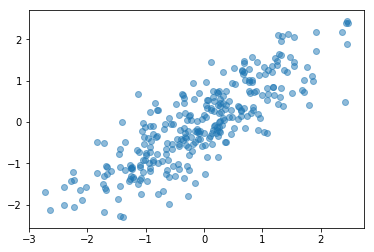

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

x = data[:, 0]
y = data[:, 1]

plt.scatter(x, y, alpha=0.5)

In [52]:
alpha = 1.01

n = 300
x = data[:, 0]
y = data[:, 1]

xdim = 1
ydim = 1

h = 5
xsigma = h * (n ** (-1 / (xdim + 4)) )
ysigma = h * (n ** (-1 / (ydim + 4)) )

xkernel = RBFkernel(sigma = xsigma)
ykernel = RBFkernel(sigma = ysigma)

print("x-kernel sigma: ", xsigma)
print("y-kernel sigma: ", ysigma)

x-kernel sigma:  1.5978858591903045
y-kernel sigma:  1.5978858591903045


In [55]:
renyi_alpha_entropy = RenyiAlphaMurualInformation(xkernel, ykernel, n)
mi = renyi_alpha_entropy.mi_alpha(x, y, alpha)
mi

/home/uchiumi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


nan